# Logistic Regressions And Decision Trees - 17 May 2017
----------------------------
## Summary
1. Expanded feature sets  , now using  4 different feature sets: <a href='#datasets'>[Link to data summary]</a>
  1. Summary statistics for acceleration magnitude: 8 features
  2. Summary statistics for triaxial accelaration: 24 features
  3. Time series of acceleration magnitude: 51 features
  4. Time series of triaxial acceleration: 153 features 

2. Normalised data for L1 regressions : now some coefficients are zero, but not many <a href='#l1_regr'>[Link to Section]</a>

3. Controlling tree complexity by choosing max depth and min_sample_split: here are some charts <a href='#tree_charts'>[Link to charts]</a>

4. All results so far : using 4 features sets and 2 different classifiers:  <a href='#results'>[Link to results]</a>

-----------------------------------------------------------

#### Imports 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import tree

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### Helper functions

In [4]:
# normalises train data set as (X - mean / stdev) and applies the same scaling to test dataset 
def train_test_normalise(x_train, x_test):
    mean = x_train.mean().T
    std = x_train.std().T
    return ((x_train - mean)/std,(x_test - mean)/std) 

In [5]:
# returns labelled model coefficients 
def model_coefficients(clf, features):
    model_coeff = pd.DataFrame(clf.coef_,columns=features, index = ['value']).T
    model_coeff['abs_value'] = abs(model_coeff.value)
    model_coeff = model_coeff.sort_values('abs_value', ascending = False)
    return model_coeff

In [6]:
def model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='', data_name='', info=''):
    result = pd.DataFrame({'data_set': data_name,
                           'num_feat': len(X_train.columns), 
                           'classifier': clf_name, 
                           'info': info,
                           'train_accuracy': metrics.accuracy_score(y_train, clf.predict(X_train)), 
                           'train_precision': metrics.precision_score(y_train, clf.predict(X_train)), 
                           'train_recall': metrics.recall_score(y_train, clf.predict(X_train)),
                           'test_accuracy': metrics.accuracy_score(y_test, clf.predict(X_test)), 
                           'test_precision': metrics.precision_score(y_test, clf.predict(X_test)), 
                           'test_recall': metrics.recall_score(y_test, clf.predict(X_test)),
                          },
                          index = [0])
    columns = ['data_set','num_feat','classifier','test_accuracy','test_precision','test_recall',
              'train_accuracy','train_precision','train_recall','info']
    result = result[columns]
    return result                                                                   

#### Read in data dictionary for available datasets

<a id='datasets'></a>

In [7]:
data_dict = pd.read_csv('data/data_dict.csv', index_col = 0)
data_dict

,name,desc,num_features,file,normalise
id,,,,,
1,magn_stats,Summary statistics on acceleration magnitude,8,data/magn_stats.csv,1
2,triax_stats,Summary statistics on triaxial acceleration,24,data/triax_stats.csv,1
3,magn_ts,Time series of acceleration magnitude,51,data/magn_ts.csv,0
4,triax_ts,Time series of triaxial accelaration - raw data,153,data/triax_ts.csv,0


## Logistic Regressions

In [8]:
# regularisation params
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

### Run L1 regressions in order to see feature selection 


<a id='l1_regr'></a>

In [9]:
# using summary statistics
for data_id  in [1,2]:
    # get data 
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file') 
    need_normalise = data_dict.get_value(data_id,'normalise') 
    print 'Model coefficients for Logistic regression with L1 penalty. Dataset:', data_name
    data = pd.read_csv(file_name, index_col = 0)
    # split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data['fall'], random_state = 42, test_size = 0.4)
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    # fit model     
    clf = LogisticRegressionCV(Cs=Cs,penalty='l1',solver = 'liblinear',cv = 5) 
    clf.fit(X_train, y_train)
    # print results
    print model_coefficients(clf, X_train.columns)
    print '-------------------------'

Model coefficients for Logistic regression with L1 penalty. Dataset: magn_stats
             value  abs_value
acc_max   2.149180   2.149180
jerk_std -1.159118   1.159118
jerk_min -0.639210   0.639210
acc_min   0.418522   0.418522
jerk_max  0.348092   0.348092
jerk_avg  0.203472   0.203472
acc_avg  -0.112473   0.112473
acc_std   0.000000   0.000000
-------------------------
Model coefficients for Logistic regression with L1 penalty. Dataset: triax_stats
               value  abs_value
y_min      -3.801821   3.801821
z_std       2.490292   2.490292
jerk_y_std -2.377287   2.377287
y_max       2.326366   2.326366
jerk_x_std -1.663683   1.663683
y_std      -1.656976   1.656976
jerk_z_std -1.478166   1.478166
x_max       1.115367   1.115367
y_avg       1.032113   1.032113
jerk_x_max  1.018093   1.018093
jerk_y_max  1.009353   1.009353
jerk_y_min -0.853856   0.853856
jerk_x_min -0.818253   0.818253
x_min      -0.743213   0.743213
x_std       0.632655   0.632655
jerk_z_min -0.565845   0.565845

In [10]:
# using time series of acceleration magnitude
for data_id  in [3]:
    # get data 
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file') 
    need_normalise = data_dict.get_value(data_id,'normalise') 
    print 'Model coefficients for Logistic regression with L1 penalty. Dataset:', data_name
    data = pd.read_csv(file_name, index_col = 0)
    # split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data['fall'], random_state = 42, test_size = 0.4)
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    # fit model     
    clf = LogisticRegressionCV(Cs=Cs,penalty='l1',solver = 'liblinear',cv = 5) 
    clf.fit(X_train, y_train)
    # print results
    print model_coefficients(clf, X_train.columns)

Model coefficients for Logistic regression with L1 penalty. Dataset: magn_ts
        value  abs_value
a25  0.381733   0.381733
a0  -0.226764   0.226764
a10 -0.148495   0.148495
a7  -0.126815   0.126815
a37  0.120632   0.120632
a15  0.111393   0.111393
a17  0.106818   0.106818
a44  0.088861   0.088861
a35  0.087780   0.087780
a41  0.079920   0.079920
a49  0.078403   0.078403
a2   0.075224   0.075224
a45 -0.072261   0.072261
a50 -0.071389   0.071389
a9  -0.070648   0.070648
a39  0.069900   0.069900
a27  0.069342   0.069342
a3  -0.069069   0.069069
a16 -0.063975   0.063975
a28  0.060725   0.060725
a46  0.057964   0.057964
a43 -0.056785   0.056785
a47  0.050342   0.050342
a13  0.047343   0.047343
a22  0.044184   0.044184
a42 -0.043418   0.043418
a14 -0.041370   0.041370
a36  0.040212   0.040212
a29  0.037982   0.037982
a6  -0.037585   0.037585
a33  0.036963   0.036963
a18 -0.036577   0.036577
a48 -0.035408   0.035408
a1  -0.033500   0.033500
a26  0.031154   0.031154
a38  0.026136   0.02613

### Logistic regression using cross validation to choose regularisation parameter and penalty type

In [11]:
param_grid = {'C': Cs, 'penalty':['l1','l2']}

In [12]:
res_store = pd.DataFrame()

In [13]:
# run model for all datasets
for data_id  in [1,2,3,4]:
    # get data 
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file') 
    need_normalise = data_dict.get_value(data_id,'normalise') 
    data = pd.read_csv(file_name, index_col = 0)
    # split into training and test 
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data['fall'], 
                                            random_state = 42, test_size = 0.4)
    # normalise if required
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    # grid search for parameters 
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)
    # record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr', 
                        data_name=data_name, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
res_store    

,data_set,num_feat,classifier,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,magn_stats,8,LogRegr,0.858874,0.770370,0.604651,0.872593,0.795031,0.633037,"{'penalty': 'l1', 'C': 0.1}"
0,triax_stats,24,LogRegr,0.942979,0.920382,0.840116,0.956026,0.941239,0.871414,"{'penalty': 'l2', 'C': 1}"
0,magn_ts,51,LogRegr,0.919102,0.888702,0.765988,0.924887,0.898967,0.774481,"{'penalty': 'l1', 'C': 1}"
0,triax_ts,153,LogRegr,0.826443,0.873606,0.341570,0.832660,0.890585,0.346192,"{'penalty': 'l1', 'C': 0.01}"


--------
## Decision Trees

### Controlling tree complexity

In [14]:
# try different tree depth - using 8 features
data_id = 2
# get data 
data_name = data_dict.get_value(data_id,'name')
file_name = data_dict.get_value(data_id,'file') 
need_normalise = data_dict.get_value(data_id,'normalise') 
data = pd.read_csv(file_name, index_col = 0)
# split into training and test and normalise if required
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data['fall'], random_state = 42, test_size = 0.4)
if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)

<a id='tree_charts'></a>

#### Controlling tree depth

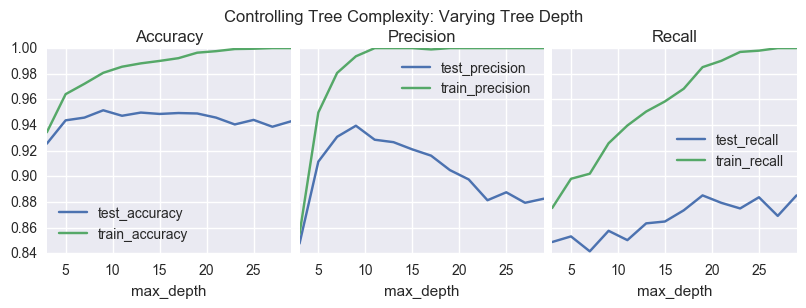

In [15]:
tree_depth = np.arange(3,30,2)
tree_store = pd.DataFrame()
for i in tree_depth:
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf.fit(X_train, y_train)
    mm = model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='Tree', 
                        data_name=data_name, info=i)
    tree_store = pd.concat([tree_store, mm])

tree_store['max_depth'] = tree_store['info']
tree_store = tree_store.set_index('max_depth')
# plot comparison 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (8,3))
tree_store[['test_accuracy','train_accuracy']].plot(title = "Accuracy", ax = ax1)
tree_store[['test_precision','train_precision']].plot(title = "Precision", ax = ax2)
tree_store[['test_recall','train_recall']].plot(title = "Recall", ax = ax3)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(top=0.85)
fig.suptitle("Controlling Tree Complexity: Varying Tree Depth")

#### Controlling min sample split

(98, 2)

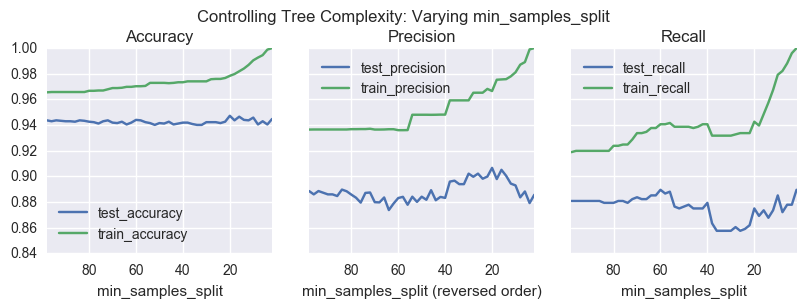

In [16]:
# try different values for min_samples_split
tree_store = pd.DataFrame()
min_samples_split = np.arange(2,100,2)
for i in min_samples_split:
    clf = tree.DecisionTreeClassifier(min_samples_split = i)
    clf.fit(X_train, y_train)
    mm = model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='Tree', 
                        data_name=data_name, info=i)
    tree_store = pd.concat([tree_store, mm])

tree_store['min_samples_split'] = tree_store['info']
tree_store = tree_store.set_index('min_samples_split') 
    
# plot comparison 
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey = True, figsize = (8,3))
tree_store[['test_accuracy','train_accuracy']].plot(title = "Accuracy", ax = ax1)
tree_store[['test_precision','train_precision']].plot(title = "Precision", ax = ax2)
tree_store[['test_recall','train_recall']].plot(title = "Recall", ax = ax3)
ax2.set_xlabel('min_samples_split (reversed order)')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(top=0.85)
fig.suptitle("Controlling Tree Complexity: Varying min_samples_split")
ax1.set_xlim(max(min_samples_split),min(min_samples_split))
ax2.set_xlim(max(min_samples_split),min(min_samples_split))
ax3.set_xlim(max(min_samples_split),min(min_samples_split))

### Use cross validation to find optimal tree complexity

In [17]:
param_grid = {'max_depth': np.arange(3,15,2), 'min_samples_split': np.arange(20,80,5)}

In [18]:
res_store_2 = pd.DataFrame()

In [19]:
# run model for all datasets
for data_id  in [1,2,3,4]:
    # get data 
    data_name = data_dict.get_value(data_id,'name')
    print data_name
    file_name = data_dict.get_value(data_id,'file') 
    need_normalise = data_dict.get_value(data_id,'normalise') 
    data = pd.read_csv(file_name, index_col = 0)
    # split into training and test 
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data['fall'], 
                                            random_state = 42, test_size = 0.4)
    # normalise if required
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    # grid search for parameters 
    clf = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv = 5)
    clf.fit(X_train, y_train)
    # record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='Tree', 
                        data_name=data_name, info=str(clf.best_params_))
    res_store_2 = pd.concat([res_store_2, mm])
res_store_2    

magn_stats
triax_stats
magn_ts
triax_ts


,data_set,num_feat,classifier,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,magn_stats,8,Tree,0.881326,0.830540,0.648256,0.915617,0.901961,0.727992,"{'min_samples_split': 40, 'max_depth': 7}"
0,triax_stats,24,Tree,0.942267,0.908385,0.850291,0.963870,0.953537,0.893175,"{'min_samples_split': 40, 'max_depth': 7}"
0,magn_ts,51,Tree,0.906272,0.887067,0.707849,0.949132,0.951302,0.830861,"{'min_samples_split': 25, 'max_depth': 9}"
0,triax_ts,153,Tree,0.915895,0.871711,0.770349,0.952698,0.945175,0.852621,"{'min_samples_split': 25, 'max_depth': 7}"


----------------------
## Results so far 

<a id='results'></a>

In [20]:
res = pd.concat([res_store, res_store_2])
res = res.sort_values('num_feat')
res

,data_set,num_feat,classifier,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall,info
0,magn_stats,8,LogRegr,0.858874,0.770370,0.604651,0.872593,0.795031,0.633037,"{'penalty': 'l1', 'C': 0.1}"
0,magn_stats,8,Tree,0.881326,0.830540,0.648256,0.915617,0.901961,0.727992,"{'min_samples_split': 40, 'max_depth': 7}"
0,triax_stats,24,LogRegr,0.942979,0.920382,0.840116,0.956026,0.941239,0.871414,"{'penalty': 'l2', 'C': 1}"
0,triax_stats,24,Tree,0.942267,0.908385,0.850291,0.963870,0.953537,0.893175,"{'min_samples_split': 40, 'max_depth': 7}"
0,magn_ts,51,LogRegr,0.919102,0.888702,0.765988,0.924887,0.898967,0.774481,"{'penalty': 'l1', 'C': 1}"
0,magn_ts,51,Tree,0.906272,0.887067,0.707849,0.949132,0.951302,0.830861,"{'min_samples_split': 25, 'max_depth': 9}"
0,triax_ts,153,LogRegr,0.826443,0.873606,0.341570,0.832660,0.890585,0.346192,"{'penalty': 'l1', 'C': 0.01}"
0,triax_ts,153,Tree,0.915895,0.871711,0.770349,0.952698,0.945175,0.852621,"{'min_samples_split': 25, 'max_depth': 7}"
